In [3]:
#!/usr/bin/env python3
# modified based on this code: https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
"""This is a enhanced version of
https://gist.github.com/ptschandl/ef67bbaa93ec67aba2cab0a7af47700b

This script exctracts variables from all logs from tensorflow event
files ("event*"),
writes them to Pandas and finally stores them a csv-file or
pickle-file including all (readable) runs of the logging directory.

Example usage:

# create csv file from all tensorflow logs in provided directory (.)
# and write it to folder "./converted"
tflogs2pandas.py . --write-csv --no-write-pkl --o converted

# creaste csv file from tensorflow logfile only and write into
# and write it to folder "./converted"
tflogs2pandas.py tflog.hostname.12345 --write-csv --no-write-pkl --o converted
"""
import glob
import os
import pprint
import traceback

import click
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame

    Parameters
    ----------
    path : str
        path to tensorflow log file

    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

In [4]:
def segment_df(df):
    imitation_rew = []
    real_rew = []
    critic_loss = []
    bc_loss = []
    actor_loss = []
    
    for itm in df:
        if 'rollout/ep_rew_mean' in itm:
            real_rew.append(itm)
        elif 'rollout/ep_imitation_mean' in itm:
            imitation_rew.append(itm)
        elif 'train/bc_loss' in itm:
            bc_loss.append(itm)
        elif 'train/actor_critic_loss' in itm:
            actor_loss.append(itm)
        elif 'train/critic_loss' in itm:
            critic_loss.append(itm)
            
    return imitation_rew, real_rew, critic_loss, bc_loss, actor_loss

In [5]:
def parse_data_from_boards(logdir_or_logfile):
    #logdir_or_logfile = "tmp/pwil/constrained_by_none/HalfCheetahBulletEnv-v0_subsampling_20_numdemo_5_random_0/20210218173556/events.out.tfevents.1613662564.users-MBP.82461.0"
    write_pkl = False
    write_csv = False
    out_dir = None

    pp = pprint.PrettyPrinter(indent=4)

    if os.path.isdir(logdir_or_logfile):
        # Get all event* runs from logging_dir subdirectories
        event_paths = glob.glob(os.path.join(logdir_or_logfile, "event*"))
    elif os.path.isfile(logdir_or_logfile):
        event_paths = [logdir_or_logfile]
    else:
        raise ValueError(
            "input argument {} has to be a file or a directory".format(
                logdir_or_logfile
            )
        )
    # Call & append
    if event_paths:
        # pp.pprint("Found tensorflow logs to process:")
        # pp.pprint(event_paths)
        all_logs = many_logs2pandas(event_paths)
        # pp.pprint("Head of created dataframe")
        # pp.pprint(all_logs.head())

        df_data = all_logs.values
        return segment_df(df_data)


In [6]:
def plot():
    for l_idx, log in enumerate(origin_logs):
        with open(origin_logs[l_idx], 'r') as read_obj:
            origin = []
            n_steps1 = []
            # pass the file object to reader() to get the reader object
            csv_reader = reader(read_obj)
            # Iterate over each row in the csv using reader object
            for idx, row in enumerate(csv_reader):
                # row variable is a list that represents a row in csv
                if idx != 0:
                    origin.append(np.float(row[2]))
                    n_steps1.append(np.int(row[1]))

        with open(acclerated_logs[l_idx], 'r') as read_obj:
            acclerated = []
            n_steps2 = []
            # pass the file object to reader() to get the reader object
            csv_reader = reader(read_obj)
            # Iterate over each row in the csv using reader object
            for idx, row in enumerate(csv_reader):
                # row variable is a list that represents a row in csv
                if idx != 0:
                    acclerated.append(np.float(row[2]))
                    n_steps2.append(np.int(row[1]))

        def smooth(y, box_pts):
            box = np.ones(box_pts)/box_pts
            y_smooth = np.convolve(y, box, mode='same')
            return y_smooth

        acclerated = np.array(acclerated)
        origin = np.array(origin)
        origin = smooth(origin, 1)



        plt.plot(n_steps1, origin,color='green', label=env_names[l_idx] + "_origin")
        plt.plot(n_steps2, acclerated, label=env_names[l_idx] + '_accelerated')


In [32]:
env_names = ['Bipedal','Ant', 'Walker2D', 'Hopper', 'HalfCheetah', 'Humanoid']
q_types = ['none', 'upper']
log_dir = '../tmp/pwil/'

# prepare dictionary to store all logs
all_log_data = {}

for qt in q_types:
    all_log_data[qt] = {}
    for env_n in env_names:
        all_log_data[qt][env_n]=[]
        
        
# recursively globe all files
for path in Path(log_dir).rglob('*.0'):
    for qt in q_types:
        for env_n in env_names:
            if (env_n in str(path)) and (("by_"+qt) in str(path)):
                try:
                    imitation_rew, real_rew, critic_loss, bc_loss, actor_loss = parse_data_from_boards(str(path))

                    imitation_rew = np.array(imitation_rew)[:,1:].astype(np.float)
                    real_rew = np.array(real_rew)[:,1:].astype(np.float)
                    critic_loss = np.array(critic_loss)[:,1:].astype(np.float)
                    bc_loss = np.array(bc_loss)[:,1:].astype(np.float)
                    actor_loss = np.array(actor_loss)[:,1:].astype(np.float)

                    data_dict = {'imitation_rew': imitation_rew, 'real_rew': real_rew, 'critic_loss': critic_loss, \
                                 'bc_loss': bc_loss, 'actor_loss': actor_loss}

                    all_log_data[qt][env_n].append(data_dict)
                except:
                    print('tensorboard parse error...')
            #print(len(all_log_data[qt][env_n]))
#print(all_log_data)

tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...
tensorboard parse error...


105801
223567
199881
174166
291247
22885
366559
0
1
2
3
4
5
1220
5792
186939
1220
4314
20248
306640
68706
3308
35762
0
1


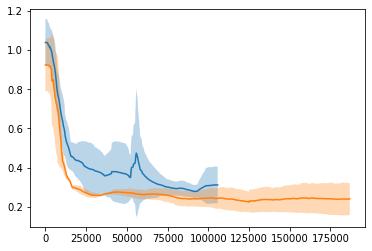

In [40]:
import baselines_plot_utils as pu

for qt in q_types:
    log_data = all_log_data[qt][env_names[0]]
    min_len = 1e20
    processed_ys = []
    for i in range(len(log_data)):
        imit_r = log_data[i]['bc_loss']
        print(np.max(imit_r[:,1].astype(np.int)))
        if np.max(imit_r[:,1].astype(np.int)) > 1e5:
            y = pu.smooth(imit_r[:,0], radius=10)
            x = imit_r[:,1].astype(np.int)
            xvals = np.linspace(0, np.max(x), np.max(x))
            yinterp = np.interp(xvals, x, y)

            if yinterp.shape[0] < min_len:
                min_len = yinterp.shape[0]
            processed_ys.append(yinterp)


    for i in range(len(processed_ys)):
        print(i)
        processed_ys[i] = processed_ys[i][:min_len]

        #plt.plot(y)

    processed_ys = np.array(processed_ys)
    ys_mean = np.mean(processed_ys, axis=0)
    ys_std = np.std(processed_ys, axis=0)
    plt.plot(ys_mean)
    plt.fill_between(range(min_len), ys_mean+ys_std, ys_mean-ys_std, alpha=0.3)